This notebook is a continuation of the work on the histograms. It focuses on analyzing the repartition of peaks given by the histograms to get information on which peaks are likely to be noise (mainly in the Fallopia sample).

In [1]:
### Import necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import matplotlib.colors as cl

In [2]:
### Fix directories

data_dir = "../data/initial database/output" #path to project folder

os.chdir(data_dir) #Select the project directory

In [3]:
### Import the data from the csv files

def select_directory(sample, file_name = "compounds", part = 1):
    """Returns the file directory corresponding to the file_name.csv file in the folder corresponding to the given sample
    (DiAcids, Fallopia, Ruthenium or Ruthenium2).
    
    the input part indicates the subfolder in which it is stored (pt1 or pt2)."""
    return data_dir + "/" + sample + "/pt" + str(part) + "/" + file_name + ".csv"

def df_from_csv(directory):
    """Extracts the csv file of the file contained in the directory and stores it in a pandas dataframe."""
    with open(directory) as file:
        return pd.read_csv(file)

#Convert the data into pandas dataframes and compute intratios.

sample_names = ["DiAcids", "Fallopia", "Ruthenium", "Ruthenium2"]

data = pd.DataFrame({"compounds" : [df_from_csv(select_directory(sample)) for sample in sample_names],
                     "peaks" : [df_from_csv(select_directory(sample, file_name = "ms2_peaks")) for sample in sample_names],
                     "spectra" : [df_from_csv(select_directory(sample, file_name = "ms2_spectra")) for sample in sample_names]
                    }, index = sample_names)

In [4]:
def peaks_in_list(sample):
    """Returns a dataframe indexed by spectrum_id with entries lists of mz, list of
    intensities and sum of intensities of the ms2 peaks corresponding to this spectrum id."""
    
    groups = data["peaks"][sample].groupby(["spectrum_id"])
    df = groups.agg(list)
    
    return df.loc[:,["mz", "intensity"]]

list_format_sp = pd.Series([peaks_in_list(sample) for sample in sample_names], index = sample_names)

In [5]:
def get_sp(sample, spectrum_id, rounded_index = False):
    """Select a spectrum in the list_format_sp dataframe."""
    if rounded_index:
        index_format = "mz"
    else:
        index_format = "mz_index"
    
    return pd.Series(list_format_sp[sample].intensity[spectrum_id],
                     index = list_format_sp[sample][index_format][spectrum_id])

In [6]:
def display(spectrum):
    """Displays a spectrum given in the form of a pandas series of the intensities indexed by mz."""
    x = spectrum.index
    plt.bar(x, spectrum, width = .5)
    plt.yscale("log")

In [7]:
plt.rcParams["figure.figsize"] = (10, 6)

prec = 500
for sample in sample_names:
    data["peaks"][sample]["mz_index"] = [int(prec * x) for x in data["peaks"][sample]["mz"]]

groupby_id = pd.Series([data["spectra"][sample].groupby("compound_id").agg(list)
                            for sample in sample_names],
                       index = sample_names)

def get_ids(compound_id, sample = "Fallopia"):
    """Returns the list of spectrum_id corresponding to the input compound_id."""
    return groupby_id[sample]["spectrum_id"][compound_id]

def select_mz(compound_id, sample = "Fallopia", level = 1):    
    """Returns a list of the mz_index of the peaks that are considered to be true peaks. The level
    indicates at which number of peaks of the same mz_index we consider it to be true."""
    
    #List all the peaks
    list_id = list(get_ids(compound_id, sample))
    all_peaks = data["peaks"][sample][data["peaks"][sample]["spectrum_id"].isin(list_id)]
    
    peaks_count = all_peaks.groupby("mz_index").mz_index.count()
    relevant_mz = list(peaks_count[peaks_count > level].index)
    
    return all_peaks[all_peaks.mz_index.isin(relevant_mz)], all_peaks[np.logical_not(all_peaks.mz_index.isin(relevant_mz))]

def noise_vs_true_plot(compound_id, sample = "Fallopia", level = 1):
    rel, irrel = select_mz(compound_id, sample, level = level)
    
    rel_mean = rel.groupby("mz_index").intensity.mean()
    
    plt.bar(np.array(rel_mean.index) / prec, rel_mean,
            width = .5,
            color = "#C90000",
            label = "averaged true peaks")
    
    plt.bar(np.array(irrel.mz_index) / prec, irrel.intensity,
            width = .3,
            alpha = .5,
            color = "#3BF0F3",
            label = "Noise")
    
    plt.yscale("log")
    plt.legend()
    plt.show()
    
    

In [8]:
def separate_noise_av(sample, level = 1):
    
    list_rel = []
    list_irrel = []
    
    a = data["compounds"][sample]["compound_id"].isin(data["spectra"][sample]["compound_id"])

    for i in data["compounds"][sample]["compound_id"][a]:
        rel, irrel = select_mz(i, sample = sample, level = level)
        list_rel.append(rel)
        list_irrel.append(irrel)

    all_true = pd.concat(list_rel)
    all_noise = pd.concat(list_irrel)

    av_true = all_true.groupby("mz_index").intensity.mean()
    av_noise = all_noise.groupby("mz_index").intensity.mean()
    return av_true, av_noise

def separate_noise(sample, level = 1):
    
    list_rel = []
    list_irrel = []
    
    a = data["compounds"][sample]["compound_id"].isin(data["spectra"][sample]["compound_id"])

    for i in data["compounds"][sample]["compound_id"][a]:
        rel, irrel = select_mz(i, sample = sample, level = level)
        list_rel.append(rel)
        list_irrel.append(irrel)

    all_true = pd.concat(list_rel)
    all_noise = pd.concat(list_irrel)
    
    return all_true["intensity"], all_noise["intensity"]

In [9]:
def plot_log_dist(sr1, sr2, nbins = 500):
    """Plots empirical distributions of the logarithms of the input pandas series."""
    
    xmin = min(np.log(sr1.min()) / np.log(10),
               np.log(sr2.min()) / np.log(10))
    
    xmax = max(np.log(sr1.max()) / np.log(10),
               np.log(sr1.max()) / np.log(10))
    
    splits = np.linspace(xmin, xmax, nbins + 1)
    
    lsr1 = np.log(sr1) / np.log(10)
    lsr2 = np.log(sr2) / np.log(10)
    
    lsr1.hist(bins = splits, color = "#C90000", alpha = .5, density = True, label = "first one")
    lsr2.hist(bins = splits, color = "#3BF0F3", alpha = .5, density = True, label = "second one")
    
    
    ticks = np.array((range(int(xmin) + 1, int(xmax) + 1)))
    plt.xticks(ticks)

    ax = plt.gca()
    ax.set_xticklabels(["1e" + str(exp) for exp in ticks])
    ax.xaxis.set_minor_locator(tk.NullLocator())

    plt.legend()

    return np.histogram(lsr1, bins = splits), np.histogram(lsr2, bins = splits)

Conclusion : the distribution of noise peaks and the distribution of real peaks overlap quite a bit for all samples, and the main presence of noise peaks doesn't happen at the same intensities, thus this noise analysis is not robust to experimental conditions.

We still get the information that noise peaks are in general of low intensity in the entire distribution of peaks and we can use the result of the analysis to adjust a threshold or a score to deal with noise peaks.

Moreover, changing the level gives the information that considering peaks to be true peaks when they appear in 40 different spectra is almost the same as asking them to appear in 10 or even 5 spectra. Later, I made the assumption that peaks are not noise as soon as they appear in two spectra, and this remark justifies that it rarely happens that intensities of noise peaks are compared with this assumption.

In [10]:
def get_ids_with_start(compound_id, sample = "Fallopia", id_start = ""):
    """Returns the list of spectrum_id starting with id_start corresponding to the input compound_id."""
    
    k = len(id_start)
    df = data["spectra"][sample].loc[[x[:k] == id_start for x in data["spectra"][sample]["spectrum_id"]]]
    groupby_id_with_start = df.groupby("compound_id").agg(list)
    return groupby_id_with_start["spectrum_id"][compound_id]

def select_mz_in_subset(compound_id, sample = "Fallopia", level = 1, id_start = ""):    
    """Returns a list of the mz_index of the peaks that are considered to be true peaks, in the subset of
    spectrum id starting with id_start. The level indicates at which number of peaks of the same mz_index
    we consider it to be true. Also returns the complementary list of the mz that are considered noise."""
    
    #List all the peaks
    list_id = list(get_ids_with_start(compound_id, sample, id_start))
    all_peaks = data["peaks"][sample][data["peaks"][sample]["spectrum_id"].isin(list_id)]
    
    peaks_count = all_peaks.groupby("mz_index").mz_index.count()
    relevant_mz = list(peaks_count[peaks_count > level].index)
    
    return all_peaks[all_peaks.mz_index.isin(relevant_mz)], all_peaks[np.logical_not(all_peaks.mz_index.isin(relevant_mz))]


#select_mz selects the mz values of the true peaks for the given compound id.

def separate_noise_in_subset(sample, level = 1, id_start = ""):
    """Return two series, one containing the intensities of peaks considered as true, and the other containing the
    intensities of peaks considered as noise, within the spectrum_id that start with id_start."""
    
    list_rel = []
    list_irrel = []
    
    k = len(id_start)
    spectra = data["spectra"][sample]
    
    a = data["compounds"][sample]["compound_id"].isin(spectra["compound_id"])

    for i in data["compounds"][sample]["compound_id"][a]:
        rel, irrel = select_mz_in_subset(i, sample = sample, level = level, id_start = id_start)
        list_rel.append(rel)
        list_irrel.append(irrel)
    
    if list_rel != []:
        all_true = pd.concat(list_rel)
    else:
        all_true = []
        
    all_noise = pd.concat(list_irrel)
    
    return all_true["intensity"], all_noise["intensity"]

In [11]:
from itertools import combinations

def select_intensity_couples(compound_id, sample = "Fallopia", level = 1, id_start = ""):    
    """Returns a list of the mz_index of the peaks that are considered to be true peaks, in the subset of
    spectrum id starting with id_start. The level indicates at which number of peaks of the same mz_index
    we consider it to be true. Also returns the complementary list of the mz that are considered noise."""
    
    #List all the peaks
    list_id = list(get_ids_with_start(compound_id, sample, id_start))
    all_peaks = data["peaks"][sample][data["peaks"][sample]["spectrum_id"].isin(list_id)]
    
    peaks_count = all_peaks.groupby("mz_index").mz_index.count()
    relevant_mz = list(peaks_count[peaks_count > level].index)
     
    return pd.Series([np.array(x) for x in combinations(all_peaks[all_peaks.mz_index.isin(relevant_mz)]["intensity"], 2)], dtype = object) 



def all_intensity_couples(sample = "Fallopia", level = 1, id_start = "R04"):
    """Returns a series of the couples of intensities of peaks with the same mz for spectras of the same compound id."""
    
    list_rel = []
    
    spectra = data["spectra"][sample]
    k = len(id_start)
    
    a = data["compounds"][sample]["compound_id"].isin(spectra["compound_id"].loc[[x[:k] == id_start for x in spectra["spectrum_id"]]])

    for i in data["compounds"][sample]["compound_id"][a]:
        rel = select_intensity_couples(i, sample = sample, level = level, id_start = id_start)
        if not rel.empty:
            list_rel.append(rel)

    return pd.concat(list_rel)

In [12]:
def color_density(sr, bins = 200):
    a1 = np.log(np.array([x[0] for x in sr])) / np.log(10)
    a2 = np.log(np.array([x[1] for x in sr])) /np.log(10)
    
    plt.figure(figsize = (10, 10))
    plt.hist2d(a1, a2, bins = bins)
    plt.show()

Now do the same analysis with intratios defined by

$$\text{intratio} = \frac{\text{peak intensity}}{\text{sum of intensities in the same spectrum}}$$

The previous histograms used intensities, which made it particularly relevant to experimental conditions, even in the same sample. Maybe using intratios could be better.

In [13]:
for sample in sample_names:
    df = data["peaks"][sample]
    intsums = df.groupby("spectrum_id")["intensity"].sum()
    df["intratio"] = df.intensity / np.array([intsums[spid] for spid in df["spectrum_id"]])   

In [14]:
def separate_noise_in_subset(sample, level = 1, id_start = ""):
    """Return two series, one containing the intensities of peaks considered as true, and the other containing the
    intensities of peaks considered as noise, within the spectrum_id that start with id_start."""
    
    #First extract subdataframes of spectra with spectrum_id starting with id_start.
    k = len(id_start)
    spectra = data["spectra"][sample].loc[[x[:k] == id_start for x in data["spectra"][sample]["spectrum_id"]]]
    peaks = data["peaks"][sample].loc[[x[:k] == id_start for x in data["peaks"][sample]["spectrum_id"]]]
    
    #Series of lists of spectrum_id having the same compound_id (indexed by compound_id).
    cid_spid = spectra.groupby("compound_id")["spectrum_id"].agg(list)
    
    #Initialize list of "relevant peaks" (not noise) and "irrelevant peaks" (ie noise).
    list_rel = []
    list_irrel = []
    
    #Runs through all the compound_id and
    for i in cid_spid.index:
        list_id = cid_spid[i]
        
        if len(list_id) > level: #Can't decide if a peak is noise or not with too few spectra.
            all_peaks = peaks[peaks["spectrum_id"].isin(list_id)]
            
            #mz_index make boxes of size 0.005, peaks are considered having the same mz if in the same box.
            peaks_count = all_peaks.groupby("mz_index").mz_index.count()
            
            #if there are enough peaks of the same mz, it is considered "relevant" (not noise).
            relevant_mz = list(peaks_count[peaks_count > level].index)
            
            #Add the result of the separation to two distinct lists.
            rel, irrel = all_peaks[all_peaks.mz_index.isin(relevant_mz)], all_peaks[np.logical_not(all_peaks.mz_index.isin(relevant_mz))]
            list_rel.append(rel)
            list_irrel.append(irrel)
    
    #Concatenate everything into two dataframes.
    if list_rel != []:
        all_true = pd.concat(list_rel)
    else:
        all_true = []
        
    all_noise = pd.concat(list_irrel)
    
    #We only care about intensities.    
    return all_true["intensity"], all_noise["intensity"]

In [15]:
sr1, sr2 = separate_noise_in_subset("Fallopia", level = 2, id_start = "R04")

In [16]:
sr1

1491       8188.264648
1492      46060.156250
13802     10353.756836
13804     60322.230469
25959      2497.097900
             ...      
28132      5330.398926
28133     35218.726562
28134      4256.378418
28135      3737.778320
28137    135537.437500
Name: intensity, Length: 12483, dtype: float64

((array([  0,   0,   0,   2,   9,  19,  33,  57,  53,  72,  84, 101,  80,
          50,  52,  66,  82, 147, 190, 278, 306, 304, 326, 361, 376, 351,
         270, 202, 207, 282, 355, 384, 373, 356, 360, 345, 352, 297, 294,
         274, 244, 249, 257, 248, 231, 207, 230, 199, 221, 191, 217, 205,
         185, 174, 177, 145, 113, 134, 118, 114,  89,  91,  70,  82,  67,
          44,  46,  42,  28,  41,  28,  32,  18,  17,  29,  19,  18,  14,
          12,   7,   5,   8,  14,  10,   7,   3,   1,   6,   5,   2,   1,
           3,   1,   1,   1,   4,   2,   1,   2,   3], dtype=int64),
  array([2.46918488, 2.52129407, 2.57340325, 2.62551244, 2.67762163,
         2.72973082, 2.78184   , 2.83394919, 2.88605838, 2.93816756,
         2.99027675, 3.04238594, 3.09449512, 3.14660431, 3.1987135 ,
         3.25082268, 3.30293187, 3.35504106, 3.40715024, 3.45925943,
         3.51136862, 3.5634778 , 3.61558699, 3.66769618, 3.71980536,
         3.77191455, 3.82402374, 3.87613292, 3.92824211, 3.9803513 ,

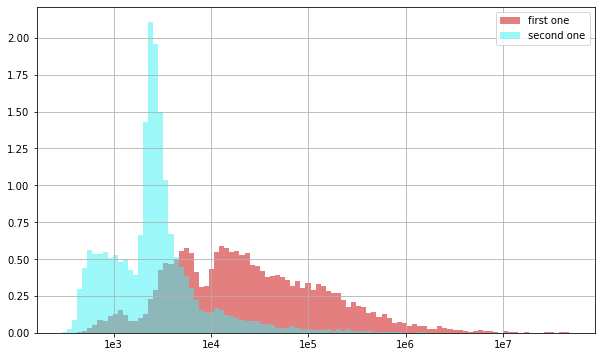

In [17]:
plot_log_dist(sr1, sr2, nbins = 100)

In [18]:
sr1, sr2 = separate_noise_in_subset("Fallopia", level = 4, id_start = "")

((array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            1,    0,    2,    1,    3,    2,    0,    8,   12,   19,   19,
           39,   53,   50,   51,   81,  105,  111,  137,  160,  159,  195,
          219,  232,  227,  298,  312,  304,  364,  317,  358,  378,  414,
          400,  413,  417,  440,  444,  479,  485,  477,  468,  512,  523,
          519,  589,  556,  545,  549,  546,  528,  487,  506,  507,  491,
          452,  444,  380,  417,  408,  358,  328,  335,  313,  280,  309,
          310,  324,  341,  322,  384,  414,  455,  501,  476,  541,  576,
          642,  673,  740,  827,  907,  934, 1061, 1155, 1118, 1193, 1254,
         1277, 1335, 1352, 1439, 1440, 1429, 1498, 1436, 1489, 1440, 1430,
         1487, 1473, 1478, 1449, 1432, 1388, 1475, 1458, 1372, 1399, 1444,
         1348, 1378, 1334, 1393, 1301, 1248, 1258, 1205, 1150, 1045,  986,
          831,  809,  661,  665,  635,  555,  579,  540,  572,  535,  574,
          590,  704,  709

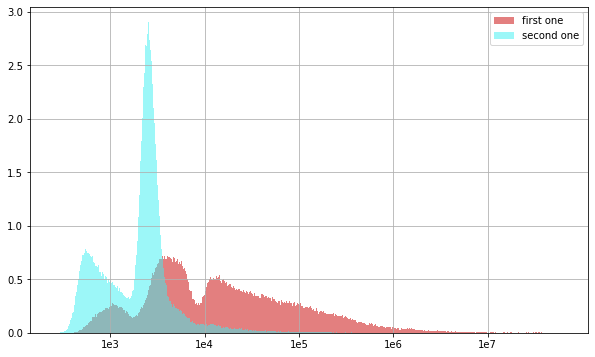

In [19]:
plot_log_dist(sr1, sr2, nbins = 500)

In [20]:
def separate_noise_by_pairs(sample, level = 1, id_start = ""):
    """Returns a series of pairs of intensities of non noise peaks in the spectra starting with
    id_start. This is to check if in one spectrum, there are all levels of intensities or if
    they all look the same."""
    
    #First extract subdataframes of spectra with spectrum_id starting with id_start.
    k = len(id_start)
    spectra = data["spectra"][sample].loc[[x[:k] == id_start for x in data["spectra"][sample]["spectrum_id"]]]
    peaks = data["peaks"][sample].loc[[x[:k] == id_start for x in data["peaks"][sample]["spectrum_id"]]]
    
    #Series of lists of spectrum_id having the same compound_id (indexed by compound_id).
    cid_spid = spectra.groupby("compound_id")["spectrum_id"].agg(list)
    
    #Initialize list of "relevant peaks" (not noise) and "irrelevant peaks" (ie noise).
    list_rel = []
    list_irrel = []
    
    #Runs through all the compound_id and
    for i in cid_spid.index:
        list_id = cid_spid[i]
        
        if len(list_id) > level: #Can't decide if a peak is noise or not with too few spectra.
            all_peaks = peaks[peaks["spectrum_id"].isin(list_id)]
            
            #mz_index make boxes of size 0.005, peaks are considered having the same mz if in the same box.
            peaks_count = all_peaks.groupby("mz_index").mz_index.count()
            
            #if there are enough peaks of the same mz, it is considered "relevant" (not noise).
            relevant_mz = list(peaks_count[peaks_count > level].index)
            
            rel_peaks = all_peaks[all_peaks.mz_index.isin(relevant_mz)]
            
            all_peaks_by_mzi = rel_peaks.groupby("mz_index").agg(list)
            
            #Add the result of the separation to two distinct lists.
            rel = [pd.Series(combinations(x, 2)) for x in all_peaks_by_mzi["intensity"]]
            list_rel += rel
        
    return pd.concat(list_rel)

In [21]:
def color_2d_notnoise(sr, bins = 200, log = True):
    """Given sr a series of couples of intensities, plot a colormap representing the density of the
    couples distribution."""
    sr1 = np.log(np.array([x[0] for x in sr])) / np.log(10)
    sr2 = np.log(np.array([x[1] for x in sr])) / np.log(10)
    
    plt.figure(figsize = (10, 10))
    
    plt.hist2d(sr1, sr2, density = True, bins = bins, range = [[2.75,6.5], [2.75, 6.5]], norm = cl.LogNorm())
    plt.show()

In [22]:
sr = separate_noise_by_pairs("Fallopia", 4, "")

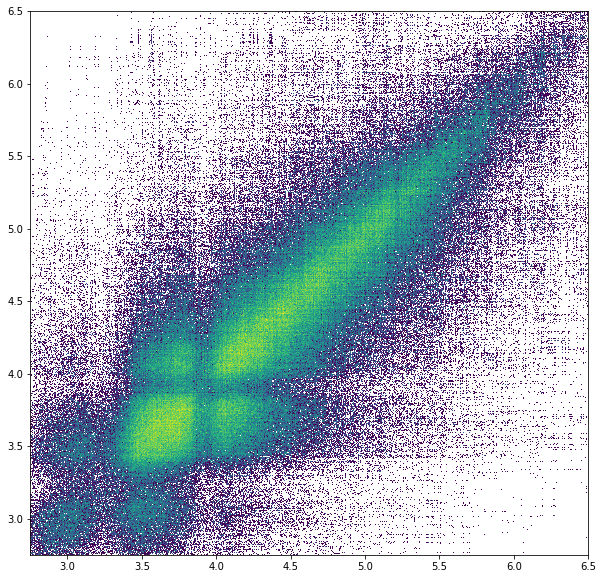

In [23]:
color_2d_notnoise(sr, bins = 1000)

In [24]:
sr = separate_noise_by_pairs("Ruthenium", 4, "")

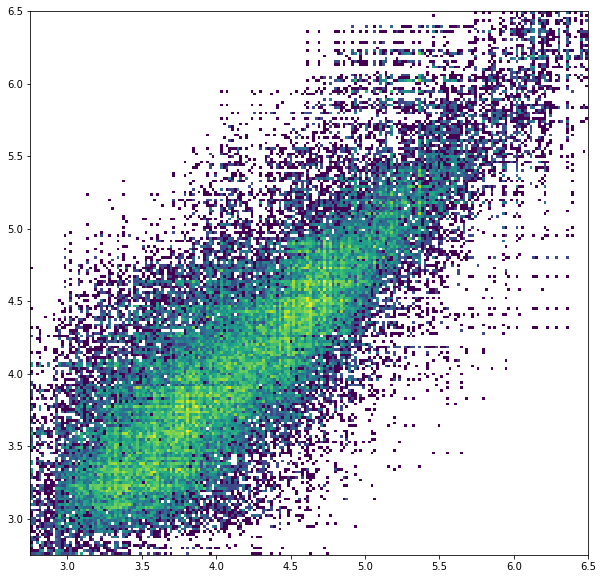

In [25]:
color_2d_notnoise(sr, bins = 200)

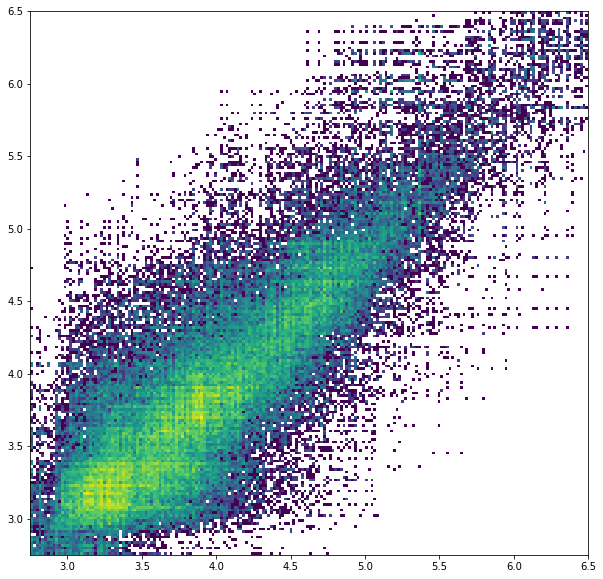

In [26]:
sr = separate_noise_by_pairs("Ruthenium2", 2, "")
color_2d_notnoise(sr, bins = 200)

In [27]:
def separate_noise(sample, level = 1, id_start = ""):
    """Return two series, one containing the intensities of peaks considered as true, and the other containing the
    intensities of peaks considered as noise, within the spectrum_id that start with id_start."""
    
    #First extract subdataframes of spectra with spectrum_id starting with id_start.
    k = len(id_start)
    spectra = data["spectra"][sample].loc[[x[:k] == id_start for x in data["spectra"][sample]["spectrum_id"]]]
    peaks = data["peaks"][sample].loc[[x[:k] == id_start for x in data["peaks"][sample]["spectrum_id"]]]
    
    #Series of lists of spectrum_id having the same compound_id (indexed by compound_id).
    cid_spid = spectra.groupby("compound_id")["spectrum_id"].agg(list)
    
    #Initialize list of "relevant peaks" (not noise) and "irrelevant peaks" (ie noise).
    list_rel = []
    list_irrel = []
    
    #Runs through all the compound_id and
    for i in cid_spid.index:
        list_id = cid_spid[i]
        
        if len(list_id) > level: #Can't decide if a peak is noise or not with too few spectra.
            all_peaks = peaks[peaks["spectrum_id"].isin(list_id)]
            
            #mz_index make boxes of size 0.005, peaks are considered having the same mz if in the same box.
            peaks_count = all_peaks.groupby("mz_index").mz_index.count()
            
            #if there are enough peaks of the same mz, it is considered "relevant" (not noise).
            relevant_mz = list(peaks_count[peaks_count > level].index)
            
            #Add the result of the separation to two distinct lists.
            rel, irrel = all_peaks[all_peaks.mz_index.isin(relevant_mz)], all_peaks[np.logical_not(all_peaks.mz_index.isin(relevant_mz))]
            list_rel.append(rel)
            list_irrel.append(irrel)
    
    #Concatenate everything into two dataframes.
    if list_rel != []:
        all_true = pd.concat(list_rel)
    else:
        all_true = []
        
    all_noise = pd.concat(list_irrel)
    
    #We only care about intensities.    
    return all_true, all_noise

In [28]:
def separate_noise_intratio_pairs(sample, level = 1, id_start = ""):
    """Returns a series of pairs of intensities of non noise peaks in the spectra starting with
    id_start. This is to check if in one spectrum, there are all levels of intensities or if
    they all look the same."""
    
    #First extract subdataframes of spectra with spectrum_id starting with id_start.
    k = len(id_start)
    spectra = data["spectra"][sample].loc[[x[:k] == id_start for x in data["spectra"][sample]["spectrum_id"]]]
    peaks = data["peaks"][sample].loc[[x[:k] == id_start for x in data["peaks"][sample]["spectrum_id"]]]
    
    #Series of lists of spectrum_id having the same compound_id (indexed by compound_id).
    cid_spid = spectra.groupby("compound_id")["spectrum_id"].agg(list)
    
    #Initialize list of "relevant peaks" (not noise) and "irrelevant peaks" (ie noise).
    list_rel = []
    list_irrel = []
    
    #Runs through all the compound_id and
    for i in cid_spid.index:
        list_id = cid_spid[i]
        
        if len(list_id) > level: #Can't decide if a peak is noise or not with too few spectra.
            all_peaks = peaks[peaks["spectrum_id"].isin(list_id)]
            
            #mz_index make boxes of size 0.005, peaks are considered having the same mz if in the same box.
            peaks_count = all_peaks.groupby("mz_index").mz_index.count()
            
            #if there are enough peaks of the same mz, it is considered "relevant" (not noise).
            relevant_mz = list(peaks_count[peaks_count > level].index)
            
            rel_peaks = all_peaks[all_peaks.mz_index.isin(relevant_mz)]
            
            all_peaks_by_mzi = rel_peaks.groupby("mz_index").agg(list)
            
            #Add the result of the separation to two distinct lists.
            rel = [pd.Series(combinations(x, 2)) for x in all_peaks_by_mzi["intratio"]]
            list_rel += rel
        
    return pd.concat(list_rel)

In [29]:
df_rel, df_noise = separate_noise("Fallopia", level = 2, id_start = "")

In [30]:
sr_rel = df_rel["intratio"]
sr_noise = df_noise["intratio"]

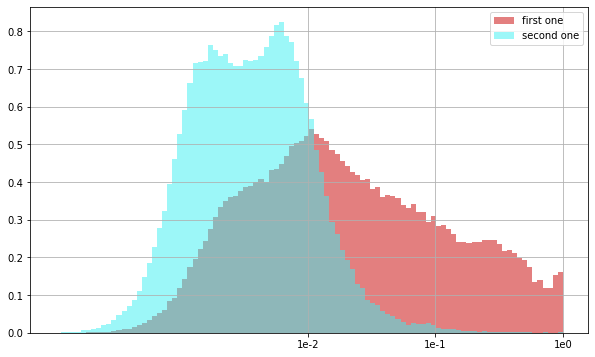

In [31]:
L = plot_log_dist(sr_rel, sr_noise, nbins = 100)
plt.show()

In [32]:
df_rel_ru, df_noise_ru = separate_noise("Ruthenium2", level = 2, id_start = "")

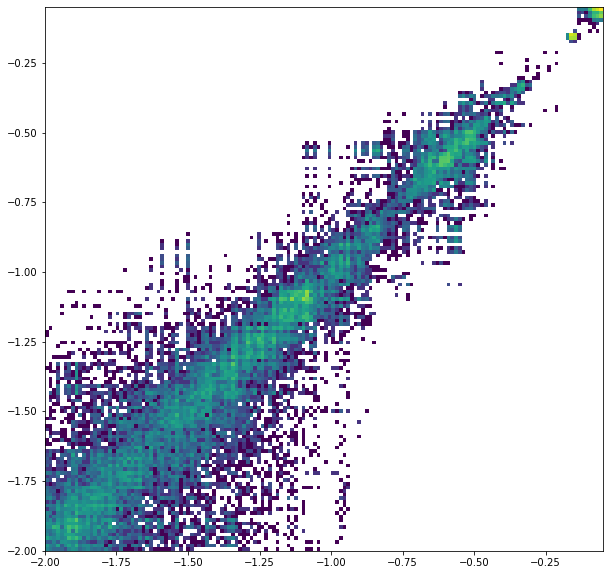

In [33]:
sr = separate_noise_intratio_pairs("Ruthenium", level = 2, id_start = "")
sr1 = np.array([x[0] for x in sr])
sr2 = np.array([x[1] for x in sr])
lsr1 = np.log(sr1) / np.log(10)
lsr2 = np.log(sr2) / np.log(10)
plt.figure(figsize = (10, 10))
plt.hist2d(lsr1, lsr2, density = True, bins = 150, range = [[-2, -0.05], [-2, -0.05]], norm = cl.LogNorm())
plt.show()

In [34]:
sr = separate_noise_intratio_pairs("Fallopia", level = 2, id_start = "")
sr1 = np.array([x[0] for x in sr])
sr2 = np.array([x[1] for x in sr])

In [35]:
lsr1 = np.log(sr1) / np.log(10)
lsr2 = np.log(sr2) / np.log(10)

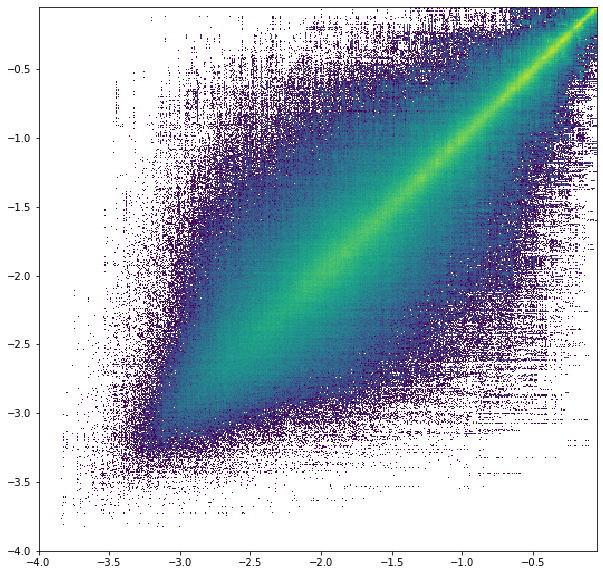

In [36]:
plt.figure(figsize = (10, 10))
plt.hist2d(lsr1, lsr2, density = True, bins = 500, range = [[-4, -0.05], [-4, -0.05]], norm = cl.LogNorm())
plt.show()

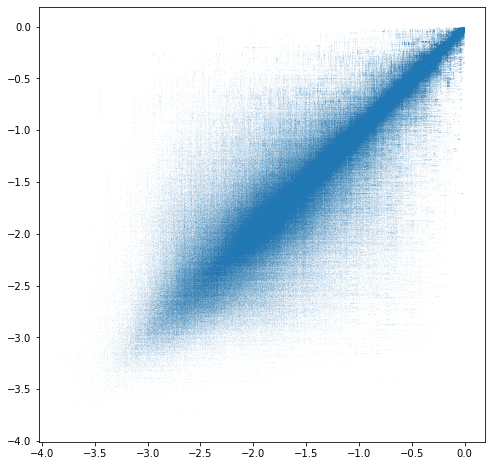

In [37]:
plt.figure(figsize = (8, 8))
plt.scatter(lsr1, lsr2, s = 0.0001)
plt.show()

In [38]:
df_rel_listed = df_rel.groupby("spectrum_id").agg(list)

In [39]:
df_rel_long = pd.DataFrame(df_rel_listed.loc[[len(x) > 3 for x in df_rel_listed["intensity"]]])

In [40]:
df_rel_long["lambda"] = [np.mean(x) for x in df_rel_long["intratio"]]

In [41]:
sr4 = [np.arccos((x + y) / np.sqrt(2 * x ** 2 + 2 * y ** 2)) for (x, y) in sr]

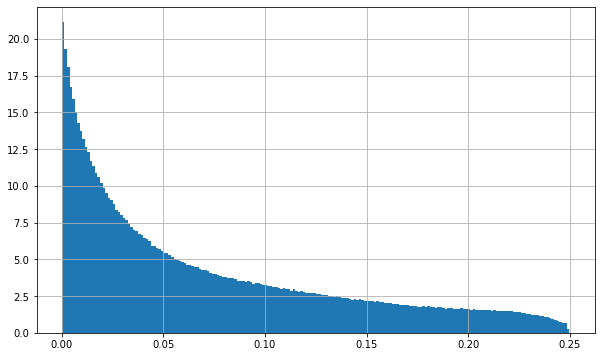

In [42]:
(pd.Series(sr4) / np.pi).hist(bins = 200, density = True)
plt.show()

In [43]:
sr5 = pd.Series(sr4) / np.pi

In [44]:
sr5.median()

0.04932130323999613

In [45]:
sr5.quantile(0.95)

0.20844361862697208

So that is not as good as it looks on the previous colorchart : although the intratios are more concentrated around being equal for the same compound, there are still a lot of couples of peaks for which it is far from the truth.

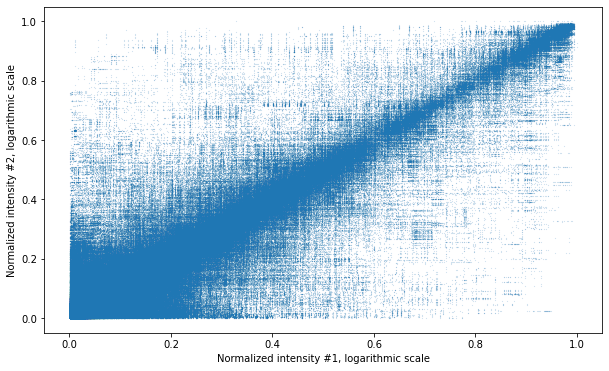

In [46]:
plt.scatter(sr1, sr2, s = .005)
plt.xlabel("Normalized intensity #1, logarithmic scale")
plt.ylabel("Normalized intensity #2, logarithmic scale")
plt.show()

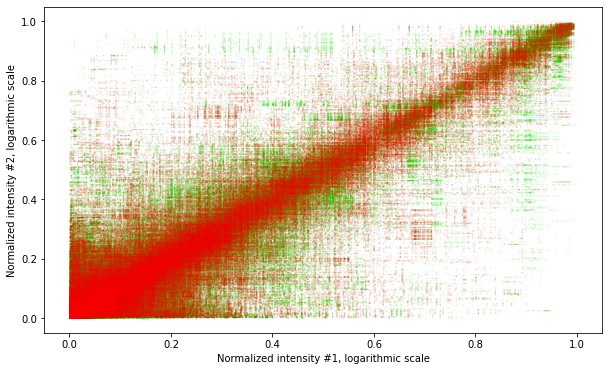

In [47]:
plt.scatter(sr1, sr2, s = .005, c = np.array([(x, 1-x, 0) for x in np.linspace(0, 1, len(sr1))]))
plt.xlabel("Normalized intensity #1, logarithmic scale")
plt.ylabel("Normalized intensity #2, logarithmic scale")
plt.show()

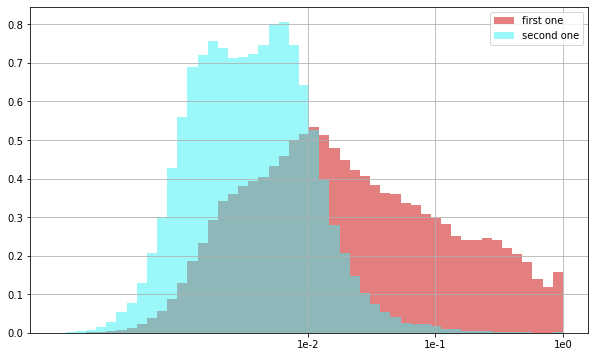

In [48]:
L = plot_log_dist(sr_rel, sr_noise, nbins = 50)
plt.show()

In [49]:
bins = L[0][1]

In [50]:
hist_count_true = L[0][0]

In [51]:
hist_count_noise = L[1][0]

In [52]:
pr_true = np.sum(hist_count_true) / (np.sum(hist_count_true) + np.sum(hist_count_noise))

In [53]:
pr_false = 1 - pr_true

In [54]:
proba_ratios = (hist_count_noise * pr_false) / (hist_count_true * pr_true)

C:\Users\maloh\AppData\Local\Temp\ipykernel_5572\870167813.py:1: RuntimeWarning: divide by zero encountered in true_divide
  proba_ratios = (hist_count_noise * pr_false) / (hist_count_true * pr_true)


In [56]:
factors = 1 / (1 + proba_ratios)

In [58]:
h = (bins[1] - bins[0]) / (bins[-1] - bins[0])

<BarContainer object of 50 artists>

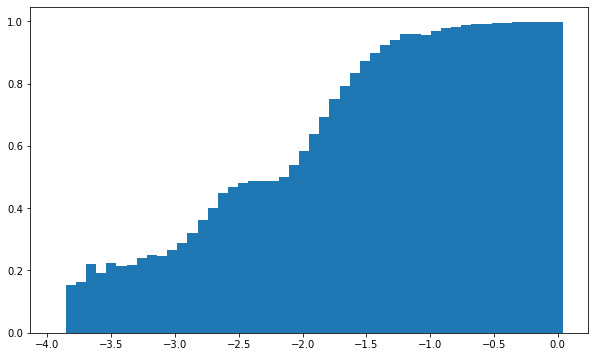

In [60]:
plt.bar(bins[1:], np.nan_to_num(factors), width = 4 * h)

In [61]:
def factor(x, a = bins[0], n = len(bins) - 1, factors = factors):
    """Return a bayesian probability weight corresponding to how likely it is that the considered peak is a true one from the
    empirical distributions of true peaks versus noise peaks.
    This factor is given by the formula :
    
    factor = 1 / (1 + [p(intratio | false) pr(false)] / [p(intratio | true) pr(true)]).
    """
    logx = np.log(x) / np.log(10)
    i = int(- n * logx / a ) + n - 1
    if i < 0:
        return 0
    elif i > n - 1:
        return 1
    else:
        return factors[i]
    
    

In [62]:
factors_sr = pd.Series(factors)

In [ ]:
sub_directory = "../data/ll_files/"

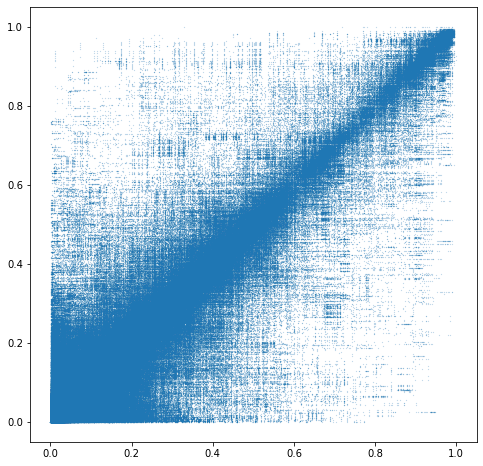

In [64]:
plt.figure(figsize = (8, 8))
plt.scatter(sr1, sr2, s = 0.01)
plt.show()

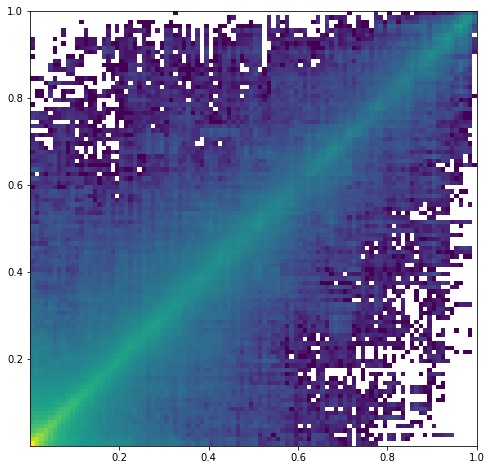

In [65]:
plt.figure(figsize = (8, 8))
plt.hist2d(sr1, sr2, density = True, bins = 100, norm = cl.LogNorm())
plt.show()

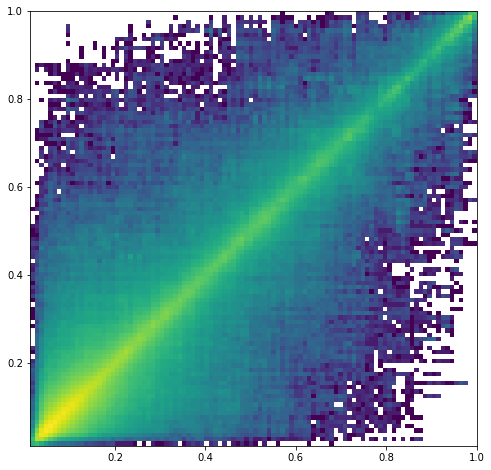

In [66]:
plt.figure(figsize = (8, 8))
plt.hist2d(np.sqrt(sr1), np.sqrt(sr2), density = True, bins = 100, norm = cl.LogNorm())
plt.show()

In [67]:
means = pd.Series((sr1 + sr2) / 2)

In [68]:
means_large = means[means > .05]

<AxesSubplot:>

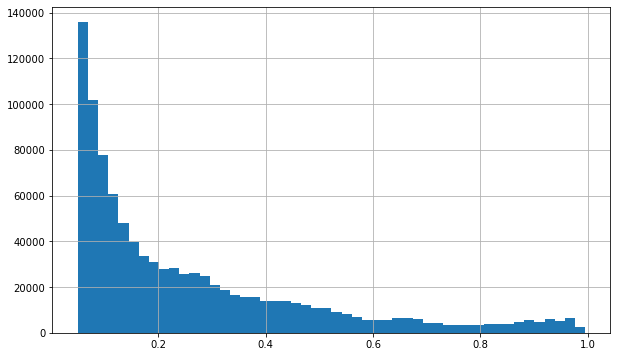

In [69]:
means_large.hist(bins = 50)

In [70]:
sr1_large = sr1[means > .05]
sr2_large = sr2[means > .05]
means_large = np.array(means[means > .05])

df_large = pd.DataFrame({"sr1" : sr1_large, "sr2" : sr2_large, "means" : means_large})




In [71]:
new_df_large = df_large.sort_values("means", ignore_index = True)

In [72]:
number = 1000

diffs = abs(new_df_large.sr1 - new_df_large.sr2)
squared_diffs = (new_df_large.sr1 - new_df_large.sr2) ** 2
sr_x = [(new_df_large.means[i + number - 1] + new_df_large.means[i]) / 2 for i in range(0, len(df_large) - number, number)]
sr_diff = [np.mean(diffs[i : i + number]) for i in range(0, len(df_large) - number, number)]
sr_squared_diff = [np.mean(squared_diffs[i : i + number]) for i in range(0, len(means_large) - number, number)]

df_compare = pd.DataFrame({"x" : sr_x, "diff" : sr_diff, "squared_diff" : sr_squared_diff})

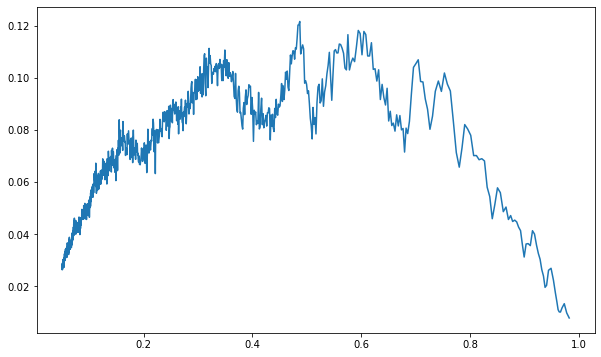

In [74]:
plt.plot(df_compare["x"], df_compare["diff"])

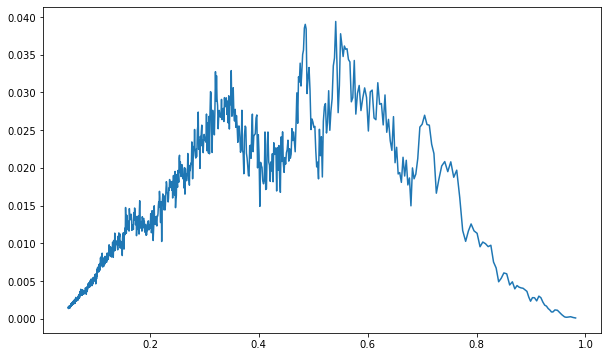

In [75]:
plt.plot(df_compare["x"], df_compare["squared_diff"])

In [76]:
splits = np.linspace(.05, 1, 95) #boxes of size 1/100.
sr_x = []
sr_diff = []
sr_squared_diff = []
for i in range(len(splits) - 1):
    slicer = np.logical_and((new_df_large["means"] >= splits[i]), (new_df_large["means"] < splits[i + 1]))
    sr_x.append((np.array(new_df_large.means[slicer])[-1] + np.array(new_df_large.means[slicer])[0]) / 2)
    sr_diff.append(np.mean(diffs[slicer]))
    sr_squared_diff.append(np.mean(squared_diffs[slicer]))

df_compare = pd.DataFrame({"x" : sr_x, "diff" : sr_diff, "squared_diff" : sr_squared_diff})
    
    
    

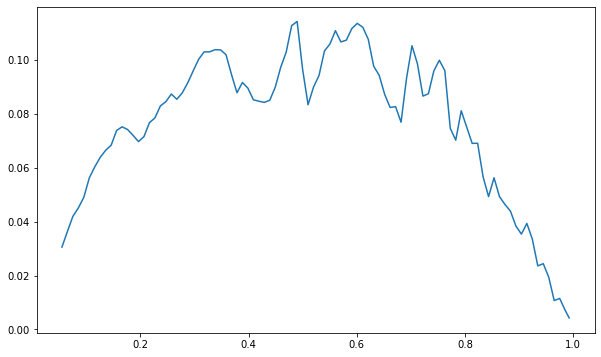

In [78]:
plt.plot(df_compare["x"], df_compare["diff"])
plt.show()

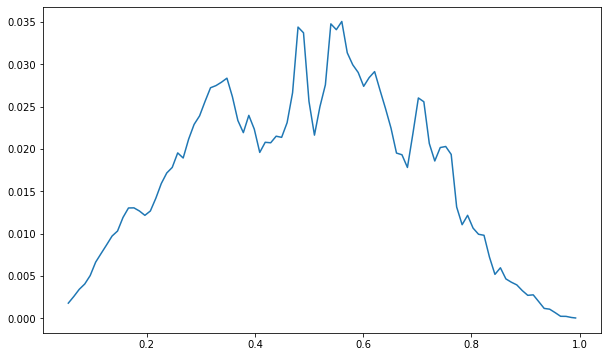

In [79]:
plt.plot(df_compare["x"], df_compare["squared_diff"])
plt.show()

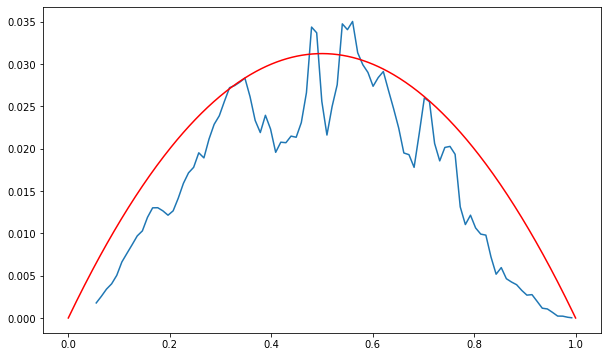

In [80]:
plt.plot(df_compare["x"], df_compare["squared_diff"])
x = np.linspace(0, 1, 500)
mu = 1 / 8
plt.plot(x, mu * x * (1 - x), c = "r")
plt.show()

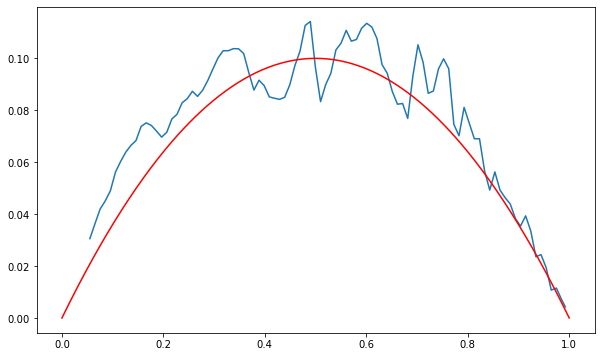

In [81]:
plt.plot(df_compare["x"], df_compare["diff"])
x = np.linspace(0, 1, 500)
mu = 1 / 2.5
plt.plot(x, mu * x * (1 - x), c = "r")
plt.show()

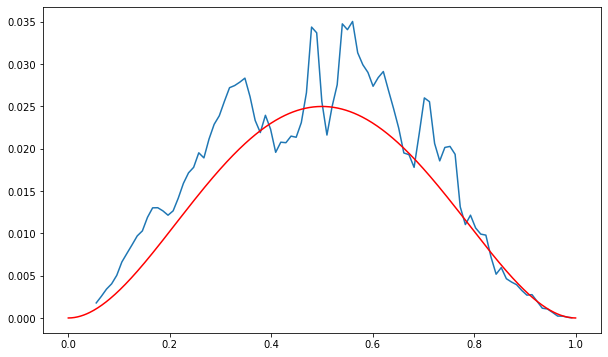

In [82]:
plt.plot(df_compare["x"], df_compare["squared_diff"])
x = np.linspace(0, 1, 500)
mu = 1 / 2.5
plt.plot(x, mu * (x * (1 - x)) ** 2, c = "r")
plt.show()

In [83]:
x = np.array(df_compare["x"])
y = np.array(df_compare["squared_diff"])

mu = np.sum(x * (1 - x) * y) / np.sum((x * (1-x))**2)

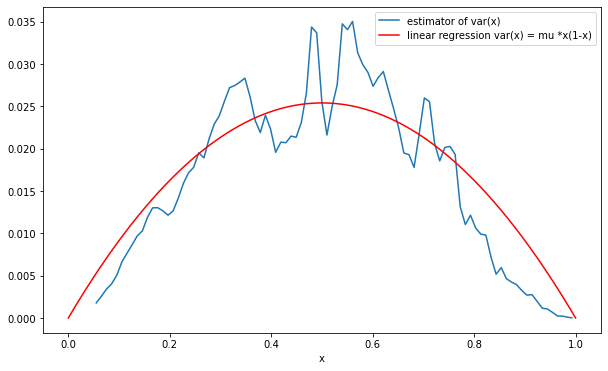

R =  0.9469609339534238
mu =  0.10167935232095487


In [84]:
x = np.array(df_compare["x"])
y = np.array(df_compare["squared_diff"])

mu = np.sum(x * (1 - x) * y) / np.sum((x * (1-x))**2)

R = 1 / (len(y) - 1) * np.sum((x * (1 - x) - np.mean(x * (1-x))) * (y - np.mean(y))) / (np.std(x * (1-x)) * np.std(y))


plt.plot(df_compare["x"], df_compare["squared_diff"], label = "estimator of var(x)")
x = np.linspace(0, 1, 500)
plt.plot(x, mu * (x * (1 - x)), c = "r", label = "linear regression var(x) = mu *x(1-x)")
plt.xlabel("x")
plt.legend()
plt.show()

print("R = ", R)
print("mu = ", mu)

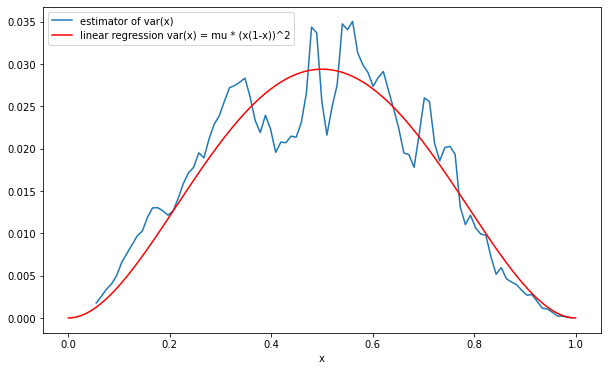

R =  0.9532750037954624
mu =  0.47049088983301396


In [85]:
x = np.array(df_compare["x"])
y = np.array(df_compare["squared_diff"])

lx = (x * (1 - x)) ** 2

R = 1 / (len(y) - 1) * np.sum((lx - np.mean(lx)) * (y - np.mean(y))) / (np.std(lx) * np.std(y))

mu = np.sum((x * (1 - x)) ** 2 * y) / np.sum(((x * (1-x))**2)**2)
plt.plot(df_compare["x"], df_compare["squared_diff"], label = "estimator of var(x)")
x = np.linspace(0, 1, 500)
plt.plot(x, mu * (x * (1 - x))**2, c = "r", label = "linear regression var(x) = mu * (x(1-x))^2")
plt.xlabel("x")
plt.legend()
plt.show()

print("R = ", R)
print("mu = ", mu)

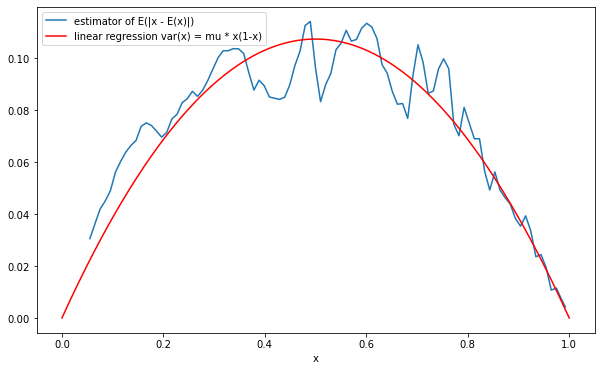

R =  0.9510780874879513
mu =  0.42976468098621007


In [88]:
x = np.array(df_compare["x"])
y = np.array(df_compare["diff"])

mu = np.sum(x * (1 - x) * y) / np.sum((x * (1-x))**2)

R = 1 / (len(y) - 1) * np.sum((x * (1 - x) - np.mean(x * (1-x))) * (y - np.mean(y))) / (np.std(x * (1-x)) * np.std(y))

plt.plot(df_compare["x"], df_compare["diff"], label = "estimator of E(|x - E(x)|)")
x = np.linspace(0, 1, 500)
plt.plot(x, mu * (x * (1 - x)), c = "r", label = "linear regression var(x) = mu * x(1-x)")
plt.xlabel("x")
plt.legend()
plt.show()

print("R = ", R)
print("mu = ", mu)

In [87]:
1 / (1 / 0.10167935232095487 - 1)

0.11318826143388745